In [104]:
# Initialize Otter
import otter
grader = otter.Notebook("ProjPart2.ipynb")

# Project - Part 2: Predicting Housing Prices in Cook County

## Due on Gradescope

## NO LATE SUBMISSIONS will be accepted - you must plan accordingly.

## Collaboration Policy

Please see the **Course Syllabus for the Collaboration Policy**.

On the other hand, the following are some **examples of things which would NOT usually be
considered to be cheating**:
 - Working on a HW problem on your own first and then discussing with a classmate a particular part in the problem solution where you are stuck.  After clarifying any questions you should then continue to write your solution independently.
 - Asking someone (or searching online) how a particular construct in the language works.
 - Asking someone (or searching online) how to formulate a particular construct in the language.
 - Asking someone for help in finding an error in your program.  
 - Asking someone why a particular construct does not work as you expected in a given program.
   

To test whether you are truly doing your own work and retaining what you've learned you should be able to easily reproduce from scratch and explain a HW solution that was your own when asked in office hours by an Instructor or on a quiz/exam.   


If you have difficulty in formulating the general solution to a problem on your own, or
you have difficulty in translating that general solution into a program, it is advisable to see
your instructor.

We are here to help!  Visit OH Hours and/or post questions on Piazza!


## Introduction

In Part 1 of this project, you performed some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset, cleaning the data as well in the process.

In Part 2 of the project, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this assignment - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`
- Using `scikit-learn` to build and fit linear models

## Score Breakdown

Question | Manual | Points
----|----|----
1abd | Yes | 8
1c | No | 1
2a | Yes | 3
2b | No | 1
3 | No | 8
4 | No | 11
5 | Yes | 14
6 | Yes | 4
Total | | 50 | 32
Extra Credit| Yes| Up to +10

In [105]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training and test data.

In [106]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project, you will train a model on the training/validation set then use this model to predict the `Sale Price`s of the test set. In the cell below, we load the training/validation set into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [107]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [108]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook). **If you did not attempt Project Part 1,** you should take some time to familiarize yourself with the codebook before moving forward.

In [109]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset.

**You should read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/95692/files/71805013?module_item_id=5035681) on Canvas explaining the context and history surrounding this dataset before attempting this section.**

<br>

--- 

### Question 1a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price to be high or low.**

1. Homeowners - Generally speaking, the higher a home's value, the higher the property taxes are for that home. Because of this, homeowners have a mixed interest in housing prices. Some may want their properties to be appraised as high as possible to increase their equity and increase resale value, at the expense of higher property taxes. Other homeowners may want a lower appraisal to avoid property tax increases. This could be split into two parties. Typically a higher income or net worth homeowner is interested in a higher appraisal as the property tax increase is less of a financial burden, they might be more aware and capable of taking advantage of property tax tax write offs, and tend to have the priviledge of being able to focus on building long term wealth in the form of equity or investments. For lower income or net worth homeowners, a property tax increase can be a significant financial burden, and often leads to these homeowners being priced out of their homes in areas that are rapidly gentrifying. In the case of homeowners who may benefit from a higher appraisal, it is worth mentioning that the property assessment used in property tax adjustments is separate from the appraisal used for sale prices. While these are often related, they are distinct, so there could be an under assessed property with disproportionally low property taxes that still sells for a high price, which is the best of both worlds for these homeowners. 

2. Cook County Assessor's Office - Ideally, this party has no interest in seeing high or low housing prices and is focused on an accurate assessment for every property. Realistically, this might not be the case, as I imagine we might see further into this project. If there was to be an influence on assessment values, I'd expect it to increase assessed property values, leading to higher property taxes collected by the local government. 

3. Real Estate Professionals - Real estate agents and developers would benefit from higher property values, which would increase their commissions and investment appeals. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.


In my mind, all of these are unfair, though I'd say that C is the most unfair. In scenarios A and B, the home is over or under assessed, so the homeowner will be paying more or less property tax than they should be. In scenario A, the home is over assessed, so the homeowner is paying more than their fair share of property taxes, which is obviously unfair. Scenario B, where the homeowner is paying less than their fair share of property taxes, might not be viewed as unfair by that homeowner, though I still consider it unfair. Property taxes often fund a variety of public services and infrastructure, like schools, police or fire departments, roads, bridges, streetlights, local parks, public health initiatives, etc. The homeowner who pays less in property taxes can and likely does utilize these public services, though without supporting them proportionally. This creates an imbalance where the other taxpayers cover the shortfall. So while the individual homeowner benefits, this undermines the equity of the system as a whole. Scenarios A and B don't sound indicative of a larger problem though, they could just be singular mistakes or outliers. At the very least, scenarios A and B don't necessarily include a property assessment process that is systematically unfair. 

Both scenarios C and D include a systematic valuation problem that impacts many homeowners, making them far more damaging and unfair in my eyes. In scenario C, this flawed assessment process overvalues inexpensive properties and undervalues expensive ones. To me, this seems particularly unfair because it places a disproportionate tax burden on homeowners with less expensive properties, who often have fewer resources to absorb higher tax rates. At the same time, wealthier homeowners benefit from lower taxes. This systemic unfairness would worsen existing inequality and perpetuate economic disparities, so I feel that it is the most unfair scenario. 

Scenario D, where inexpensive properties are undervalued and expensive properties are overvalued shares the systemic aspect of scenario C, but doesn't seem as immediately harmful as scenario C. Wealthier homeowners would bear a larger share of the tax burden, though they are likely more equipped to do so. This would likely benefit lower income homeowners to some extent, as they would pay less in taxes, but I expect it would cause some issues as well. For example, low and high value homes aren't typically homogenous in an area, there are usually clusters or neighborhoods that are predominantly one or the other. As we mentioned above, property taxes support a variety of public services, and these are often funded by the taxes from the surrounding area. So in this situation where inexpensive properties, which are likely grouped together and funding the same local public services, are undervalued and contributing less to these public services, I think its reasonable to assume these public services would suffer. While the outcome or intent of this could be viewed as a Robin Hood-esque redistribution of wealth, shifting the tax burden to wealthier homeowners and giving relief to the less fortunate, a targeted and deliberate redistribution from intentional policy, not a systemic flaw, would be a better approach. As much as the idea of redistributing wealth is redeeming in my eyes, and does seem "fair" to some degree, I can't call this scenario fair, ideal, or sustainable. 


<!-- END QUESTION -->

---

### Question 1c

Consider a model that is fit to $n = 50$ training observations. We denote the response as $y$ (Log Sale Price), the prediction as $\hat{y}$, and the corresponding residual to be $y - \hat{y}$. Which residual plot corresponds to a model that might make property assessments that result in regressive taxation? (Refer to the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/95692/files/71805013?module_item_id=5035681) for a reminder of the definition of regressive taxation).  Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q1c` to the string letter corresponding to your plot choice.

**Hint:** When a model overvalues a property (predicts a `Sale Price` greater than the actual `Sale Price`), what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

<img src='res_plots.png' width="900px" />


In [110]:
q1c = 'A'

In [111]:
grader.check("q1c")

q1c results: All test cases passed!

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

**You should read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/95692/files/71805013?module_item_id=5035681) explaining the history about this dataset before answering the following question.**

<!-- BEGIN QUESTION -->

### Question 1d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to **read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/95692/files/71805013?module_item_id=5035681) explaining the context and history of this dataset  before answering this question).**

There were several central problems in the tax system in Cook County identified by the Chicago Tribune. For one, they found regressive taxation, where lower value homes were consistently over assessed, leading to a disproportionately high property taxes for lower income homeowners. At the same time, higher value homes were under assessed, so wealthier homeowners paid less than their fair share of taxes. Alongside this, there were racial disparities where the likelihood of a property being over or under assessed was strongly correlated with the racial makeup of the neighborhoods. These correlations showed that non-white, working class homeowners were likely to be paying more in property taxes relative to their home’s value than predominantly white, more affluent homeowners. 

As in most counties, there was an assessment appeals process in Cook County, though it was found to be unfair and inaccessible to those most negatively affected by the regressive taxation. Similarly to other tax and financial areas, wealthier individuals could more easily navigate the process to reduce their assessments, often through the use of legal representation, which was a luxury often inaccessible to more low income homeowners. In fact, the model and its processes were described as rife with institutional bias and corruption, with stakeholders including tax lawyers and politicians benefiting from the inequities. Additionally, there was little accountability or oversight in the system to correct these biases, so these inequities were allowed to persist for years. 

For the primary causes, Cook County had a legacy of inequitable policies. Historical practices, such as redlining and racially motivated housing policies, created lasting disparities in property values and access to public resources. Data quality was also an issue, Cook County was using outdated and inaccurate info and failed to account for neighborhood level variations and socioeconomic differences. This was largely due to poor quality data collection leading to significant gaps in the data, particularly in lower income neighborhoods. The assessment was also not designed to account for socioeconomic and racial disparities, leading to biases. This bad data quality and analysis worsened errors in assessments in these neighborhoods while the lack of transparency and opaque nature of the property assessment process made it difficult to identify and address these issues. Finally, there was some evidence of institutional bias. Policies and practices often reflect the interests of more affluent homeowners, people, and professionals, neglecting the needs of more marginalized communities. 


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 2a:  More EDA

<br>

In good news you have already done a lot of EDA with this dataset in Project 1. 

Before fitting any model, we should check for any missing data and/or unusual outliers.

Since we're trying to predict `Sale Price`, we'll start with that field.

Examine the `Sale Price` column in the `training_val_data` DataFrame and answer the following questions:


 - 2ai).  Does the `Sale Price` data have any missing, N/A, negative or 0 values for the data?  If so, propose a way to handle this.

 - 2aii).  Does the `Sale Price` data have any unusually large outlier values?  If so, propose a cutoff to use for throwing out large outliers, and justify your reasoning).  

 - 2aiii).  Does the `Sale Price` data have any unusually small outlier values?  If so, propose a cutoff to use for throwing out small outliers, and justify your reasoning.  
 
 
Below are three cells.  The first is a Markdown cell for you to write up your responses to all 3 parts above.
The second two are code cells that are available for you to write code to explore the outliers and/or visualize the Sale Price data.

### Question 2abc answer cell:**   *Put your answers in this cell...*

2ai: There are 0 missing values and no 0 or negative values, so no action is needed for this part. 

2aii: For this, we used an upper limit for outliers of 712,200 and there were 12,229 large outliers. To find this upper limit, we calculated the IQR and defined the upper limit as Q3 + 1.5 * IQR = 712,200. Because of the significant number of large outliers, this should be addressed. To do so, a IQR based cutoff of Q3 + 1.5 * IQR = 712,200 could be used to remove or treat large outliers. A transformation like log scaling would also be a good approach. Values above this threshold deviate significantly and could distort the model's predictions if this isn't addressed. 

2aiii: Yes, the Sale Price data has 35,549 unusually small outlier values. These small values are likely not reflective of the true market value of the homes. To identify these outliers, we used $10 as the cutoff, which could also be used to exclude these small outliers. Any home price below this cutoff is likely an irregular transaction from a data entry error or unique sale conditions. Including these extremely small values would distort the analysis and model predictions, they are outliers that do not represent typical sale prices. 

In [112]:
# check for missing, NaN, or 0 values in sale price
missing_values = training_val_data['Sale Price'].isna().sum()
zero_values = (training_val_data['Sale Price'] <= 0).sum()

print(f"Missing values: {missing_values}")
print(f"Zero or negative values: {zero_values}")

#######################################################################

# calc IQR to find large outliers
Q1 = training_val_data['Sale Price'].quantile(0.25)
Q3 = training_val_data['Sale Price'].quantile(0.75)
IQR = Q3 - Q1

# define upper limit for outliers
upper_limit = Q3 + 1.5 * IQR

print(f"Upper limit for outliers: {upper_limit}")

# filter large outliers
large_outliers = training_val_data[training_val_data['Sale Price'] > upper_limit]
print(f"Number of large outliers: {large_outliers.shape[0]}")

#########################################################################

# find small outliers
small_outliers = training_val_data['Sale Price'][training_val_data['Sale Price'] < 10]
print(f"Number of small outliers: {small_outliers.shape[0]}")

# your code exploring Sale Price above this line

Missing values: 0
Zero or negative values: 0
Upper limit for outliers: 712200.0
Number of large outliers: 12229
Number of small outliers: 35549


In [113]:
...
# optional extra cell for exploring code

Ellipsis

<!-- END QUESTION -->

**Pure Market Filter**

As you (hopefully) noticed, there are quite a few small values for the Sale Price of a home that don't make sense.  This can happen when someone sells a house to a relative for $\$1$ or some other price that is not reflective of the true market value.  There are also several extremely large outliers (houses that sold for more than $10 million) that don't accurately capture the true market value of a home.

It turns out, there's actually an indicator feature already available in the dataset to help filter out any sale transactions that aren't considered "Pure Market Transactions"  (for example, when someone sells a house to a relative for $\$1$, we don't consider that a transaction driven by the true market value of the house.

We'll use this indicator feature in the next section to remove non-market transactions before fitting our models.


### Question 2b

What are the max and min Sale Price values for the subset of data in the training_val dataset with the indicator `Pure Market Filter` = 1?



In [114]:
pure_market_data = training_val_data[training_val_data['Pure Market Filter'] == 1]

max_Sale_Price_filtered = int(pure_market_data['Sale Price'].max())

min_Sale_Price_filtered = int(pure_market_data['Sale Price'].min())

print("Max Sale Price:", max_Sale_Price_filtered)
print("Min Sale Price:", min_Sale_Price_filtered)

Max Sale Price: 8490078
Min Sale Price: 10003


In [115]:
grader.check("q2d")

q2d results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting a Simple Linear Regression Model

In Part 1 of the project, you plotted the log-transformed Sale Price vs the log-transformed total area covered by the building (in square feet)  and saw there was a positive linear association.  Let's start the modeling process by fitting a simple linear regression model using this predictor.  

Our first model will take the form:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Log Building Square Feet})
$$



<br>

--- 

### Question 3a:  Training/Validation Split


The data has already been split into a training_val set and a test set.  Let's further split the training_val set into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits an input DataFrame `data` into two smaller `DataFrame`s named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20%.  You should not be importing any additional libraries for this question. Your answer should use the variable `shuffled_indices` defined for you. Take a look at the `np.permutation` [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html). You should only be using `NumPy` functions to generate randomness!

**Hint:** While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any variable names of your choice) that contain a *random* 80% and 20% of the indices, respectively. Then, use these arrays to index into `data` to create your final `train` and `validation` `DataFrame`s. To ensure that your code matches our solution, use the first 80% as the training set and the last 20% as the validation set. Remember, the values you use to partition `data` must be integers!

*The provided tests use the same random seed to check that you not only answered correctly but ended up with the same train/validation split as our reference implementation. Later testing is easier this way.*

In [116]:

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    # calc the split index for 80%
    split_index = int(data_len * 0.8)
    
    #use shuffled indices to split data
    train_indices = shuffled_indices[:split_index]
    validation_indices = shuffled_indices[split_index:]
    
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    
    return train, validation

 
#This makes the train-test split in this section reproducible across different runs 
# of the notebook. DO NOT CHANGE THIS RANDOM SEED.
np.random.seed(1337)

train, valid = train_val_split(training_val_data)


In [117]:
grader.check("q3a")

q3a results: All test cases passed!

<br>

--- 
## Modeling Step 1:  Feature Transformation

<br>

## Create a pipeline to process the data

It is time to prepare the training and validation data for the model we proposed above. 

In Project Part 1, you wrote a few functions that added features to the dataset. Instead of calling them manually one by one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  



For an example of how to work with pipelines, we have processed model 1 for you using `process_data_m1` in the below cell. 



In particular the cell below completes the following steps:

  1. Creates a function `process_data_m1` to perform the following feature engineering:  
     - Removes rows in the dataset that have the indicator `Pure Market Filter`= 0 (these are outliers that are not representative of sales driven by the true housing market).
     - Applies log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
     - Selects the columns and `Log Sale Price` , `Log Building Square Feet`
     - Outputs the transformed DataFrame
 
 2. Run `process_data_m1` separately on the training data and then the validation data.  Then output the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$ for both the training data and the validation data (save them in the variable names `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`). Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix should be a `pandas` DataFrame and your observed vector should be a `pandas` Series.**.


In [118]:
# Just Run This Cell.   Make sure you understand what each part is doing - you will use this format when you expand the model


def process_data_m1(data):
    """ 
    Takes in a DataFrame `data` and performs data transformations and processing to use for Model 1
    """
    
    # Remove outliers
    data = data[data["Pure Market Filter"]==1]
    
    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    # Select columns for the model
    data = data[['Log Building Square Feet', 'Log Sale Price']]
    
    return data



# Process both the training and validation data 
processed_train_m1 = process_data_m1(train)

processed_val_m1 = process_data_m1(valid)


# Create X (dataframe) and Y (series) to input into model
X_train_m1 = processed_train_m1.drop(columns = "Log Sale Price")
Y_train_m1 = processed_train_m1["Log Sale Price"]

X_valid_m1 = processed_val_m1.drop(columns = "Log Sale Price")
Y_valid_m1 = processed_val_m1["Log Sale Price"]

# Take a look at the result
display(X_train_m1.head())
display(Y_train_m1.head())

display(X_valid_m1.head())
display(Y_valid_m1.head())


Log Building Square Feet
130829                  7.870166
193890                  7.002156
30507                   6.851185
91308                   7.228388
131132                  7.990915

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet
50636                   7.310550
82485                   7.325808
193966                  7.090077
160612                  7.281386
7028                    7.118016

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

## Modeling Step 2:  Create a linear model

Next we'll use `sci-kit learn` to train the model.



### Question 3b


We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our model. 

We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.


Fill in the rest of the code below to fit the model using the training set and then output predictions for both the training and validation set.  

In [119]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)

# Fit the model using the processed training data
linear_model_m1.fit(X_train_m1, Y_train_m1)

# Compute the predicted y values from linear model 1 (in units log sale price) using the training data and 
# again using the validation data:


Y_predict_train_m1 = linear_model_m1.predict(X_train_m1)

Y_predict_valid_m1 = linear_model_m1.predict(X_valid_m1)



In [120]:
grader.check("q3b")

q3b results: All test cases passed!

<br>


## Modeling Step 3:  Model Evaluation Using RMSE


We'll compare the performance of our models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$


### QUESTION 3c:

Complete the code below for the funtion RMSE:

In [121]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    
    # find the squared differences
    squared_diff = (predicted - actual) ** 2
    
    # calc the mean of squared differences
    mean_squared_error = squared_diff.mean()
    
    # return square root of mean squared error
    return np.sqrt(mean_squared_error) 


In [122]:
grader.check("q3c")

q3c results: All test cases passed!

### Keeping track of all the models.

In this notebook (and in life) we will want to keep track of all our models. 
For this part of the project you will be creating 3 different versions of the model.

In [123]:
# Just run this cell to create arrays to store the RMSE information from the models

model_names=["M1: log(bsqft)", "M2", "M3"]

# Create arrays where we can keep track of training and validation RMSE for each model

training_error_log = np.zeros(4)
validation_error_log = np.zeros(4)

training_error = np.zeros(4)
validation_error = np.zeros(4)

# Array to track cross validation errors average RMSE errors  

cv_error = np.zeros(4)


## QUESTION 3d:



In the cell below use your `rmse` function to calculate the training error and validation error for model 1.

Assign the RMSE of the predicted log sale prices and the actual log sale prices to the following variables: 

 `training_error_log[0]`  and    `validation_error_log[0]`


Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.  In other words we want the RMSE **with regard to `Sale Price`**. Remember to exponentiate your predictions and response vectors before computing the RMSE using the `rmse` function and assign it to the following:

`training_error[0]` and    `validation_error[0]`



In [124]:
# Training and validation RMSE for the model (in units log sale price)

training_error_log[0] = rmse(Y_predict_train_m1, Y_train_m1)
validation_error_log[0]= rmse(Y_predict_valid_m1, Y_valid_m1)


# Training and validation RMSE for the model (in its original dollar values before the log transform)

training_error[0] = rmse(np.exp(Y_predict_train_m1), np.exp(Y_train_m1))
validation_error[0] = rmse(np.exp(Y_predict_valid_m1), np.exp(Y_valid_m1))


print("1st Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(training_error_log[0], validation_error_log[0]))
print("1st Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error[0], validation_error[0]))


1st Model
Training RMSE (log): 0.7509790948543053
Validation RMSE (log): 0.7508998658616937

1st Model 
Training RMSE: 249895.90791758915
Validation RMSE: 255533.84041505



In [125]:
grader.check("q3d")

q3d results: All test cases passed!

## Modeling Step 4: Cross Validation

To check that the validation RMSE is representative of the dataset we'll also perform a 5-fold cross validation on the model.

In [126]:
# Just run this cell.  It uses 5-fold cross validation to check that our validation errors weren't a fluke.
# Make sure you understand what this code is doing, you will need it again when you update the model.

from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5) 
    de_logged_rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        de_logged_rmse_values.append(rmse(np.exp(y.iloc[va_ind]), np.exp(model.predict(X.iloc[va_ind,:]))))
    return np.mean(de_logged_rmse_values)


# Create a new model to fit on the whole training_val dataset
linear_model_m1_cv = lm.LinearRegression(fit_intercept=True)


# Process the entire training_val dataset using the pipeline
processed_full_m1 = process_data_m1(training_val_data)


# Split into X and Y:
X_full_m1 = processed_full_m1.drop(columns = "Log Sale Price")
Y_full_m1 = processed_full_m1["Log Sale Price"]

# DO NOT CHANGE THIS LINE - it ensures reproducibility 
np.random.seed(1330)

# Run Cross Validation and Output RMSE (in units of Sale Price):
cv_error[0] = cross_validate_rmse(linear_model_m1_cv, X_full_m1, Y_full_m1)
print("1st Model Cross Validation RMSE: {}".format(cv_error[0]))

1st Model Cross Validation RMSE: 250986.19718987434


## Modeling Step 5: Visualizations

## Visualizing RMSE

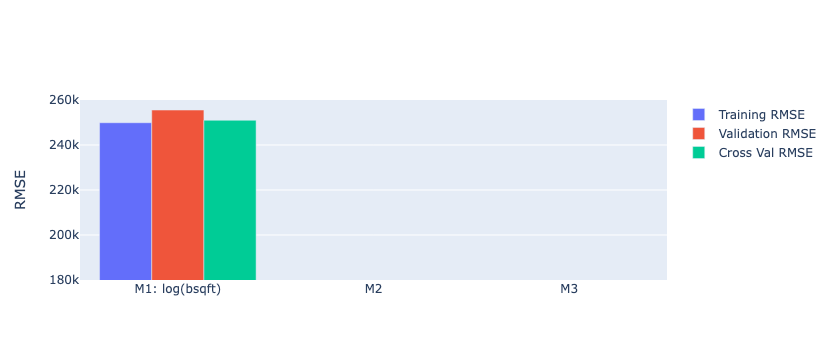

In [127]:
# Just run this cell.  It creates a visualization of the RMSE for Model 1

import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig

Notice that our RMSE is pretty high given that it's in the units of dollars and measures our error when predicting sale prices of a house.  We will want to improve this model!

<br>

--- 

## Visualizing Residual Plots

Another way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.  We will use the validation data to create these plots.

In the cells below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot
2 side-by-side residual plots:

 - The first plot should be of the residuals from predicting `Log Sale Price` using the model versus  the **predicted** `Log Sale Price` for the **validation data**. 
 - The second plot should be the residuals from predicting `Log Sale Price` using the model versus the **actual** `Log Sale Price` for the **validation data**. 

We will keep the residuals in terms of units of log to make it easier to spot trends.

With such a large dataset, it is difficult to avoid overplotting entirely. We set the dot size and opacity in the scatter plot to reduce the impact of overplotting as much as possible.

## QUESTION 3e:  Complete the code below to plot the residual plots

Text(0.5, 1.0, 'Model 1 Val Data: Residuals vs. Log(Sale Price)')

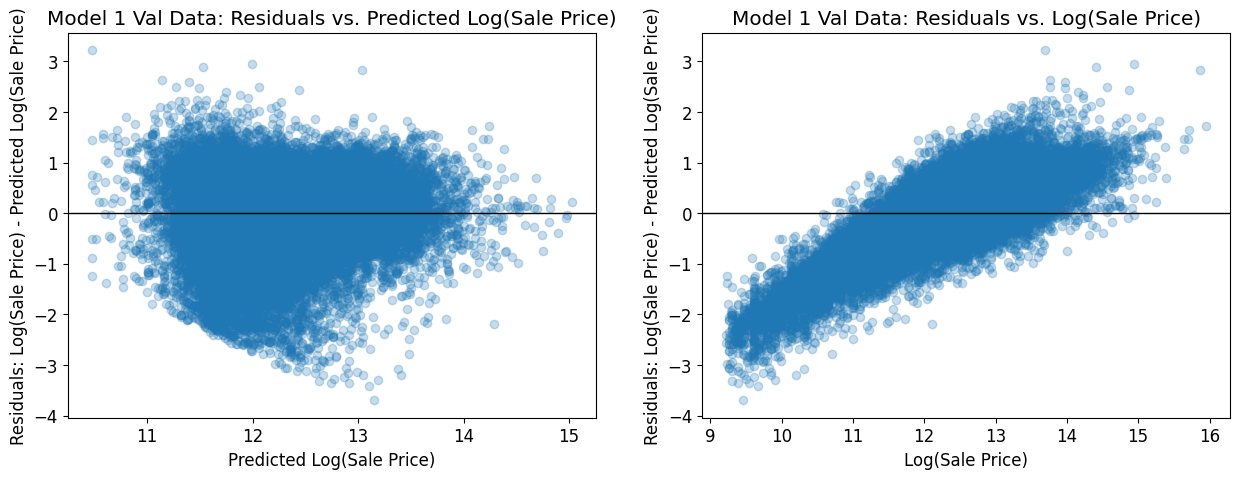

In [128]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m1  # predicted log(Sale Price)
y_plt1 = Y_valid_m1 - Y_predict_valid_m1  # residuals

x_plt2 = Y_valid_m1  # actual log(Sale Price)
y_plt2 = Y_valid_m1 - Y_predict_valid_m1  # residuals



ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 1 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 1 Val Data: Residuals vs. Log(Sale Price)")

In [129]:
grader.check("q3e")

q3e results: All test cases passed!

**NOTE** Notice in the first plot it appears that the lower part of the plot is cutoff along an angled line - this is due to us filtering the data by only considering "Pure Market Filter" = 1, it is not a "pattern" in the residuals that we should try to address.

<br>


--- 

### Question 3f

Based on the structure you see in your residual plots, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?

Assign the string "regressive", "fair" or "progressive" to `q3f` in the cell below accordingly.

In [130]:
q3f = "regressive"

In [131]:
grader.check("q3f")

q3f results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 4:  Adding a New Feature


While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 feature (out of a total of 60+) so far! 

### Choosing Candidate Predictors to Add to Model



To see if additional variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature or a transformation of it. 

In Project Part 1, you conducted feature transformation to create several other features related to the Sale Price including `Bedrooms` and `Roof Material`.
Let's examine plots of the residuals from Model 1 vs each of these features.

We have automatically imported staff implementations of the functions you wrote in Project 1 (these are stored in `feature_func.py`).  You are welcome to copy over your own implementations from Project 1 if you'd prefer. 

These functions are:
 - `remove_outliers`, 
 - `add_total_bedrooms`, 
 - `find_expensive_neighborhoods`, 
 - `add_in_expensive_neighborhood`, and 
 - `ohe_roof_material`. 


In [132]:
# Just run this cell - it creates the columns of the 2 additional features we're interested in considering 
# and appends the residual data from Model 1, so we can easily visualize

from feature_func import *


def process_data_candidates(data):
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]
    
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    
    # Create Bedrooms
    data = add_total_bedrooms(data)
     
   
    # Update Roof Material feature with names
    data = substitute_roof_material(data)
    
    # Select columns for comparing residuals
    data = data[['Log Building Square Feet',  'Roof Material', 'Bedrooms', 'Log Sale Price']]

    return data


#Since our residuals are using the validation data, we will just examine these new features on the validation dataset
    
valid_comp = process_data_candidates(valid)
    
valid_comp = valid_comp.assign(M1residuals_log=Y_valid_m1 - Y_predict_valid_m1)


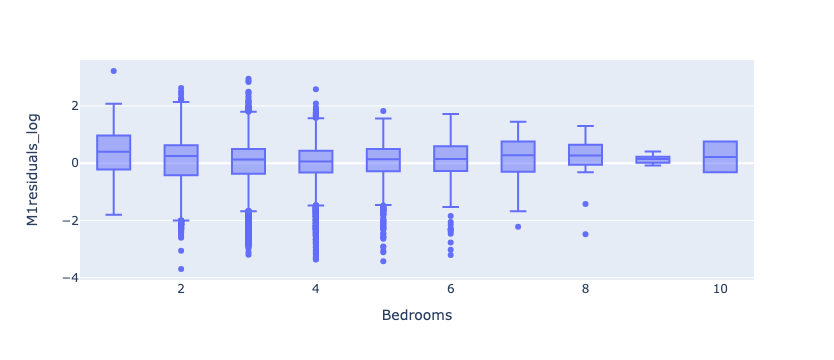

In [133]:
# Run this cell to compare residuals with Bedrooms

import plotly.express as px

px.box(valid_comp, x='Bedrooms', y='M1residuals_log')


Notice, the medians of each boxplot align pretty close to 0 on the y-axis (meaning there is no major trend in prediction errors by Number of Bedrooms).

This means we do NOT expect adding the features Bedrooms will help improve our original model.

What about Roof Material?


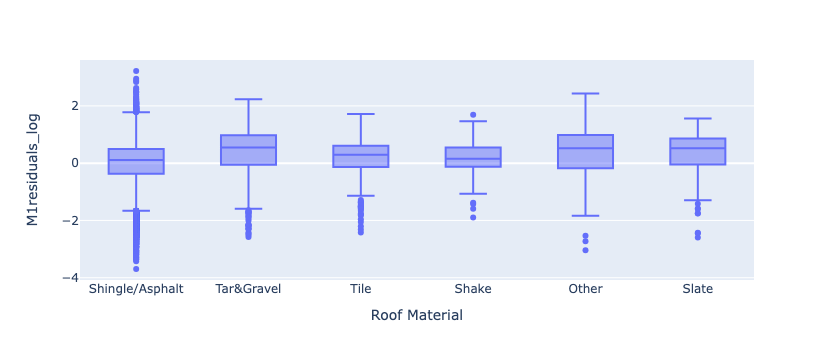

In [134]:
# Run this cell to compare residuals vs Roof Material

px.box(valid_comp, x='Roof Material', y='M1residuals_log')

The plot above shows us that the distribution of errors appears to change slightly based on Roof Material. Ideally, the median of each  box plot lines up with 0 on the y-axis (meaning there was no difference in prediction by Roof Material type). Instead, we see some variation from 0 for all except Shingle/Asphalt.   These patterns suggest that we may want to try including Roof Material in the model.


## Question 4a:  Model 2

Let's add `Roof Material` as a predictor in our model.  We will transform the column to be in terms of the Room Material names (like you did in Project Part 1, instead of the number codes).   In other words, let's consider a model of the form:

Model 2: 
$$
\text{Log Sale Price} =  \theta_1 (\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt})+ \theta_3 (\text{Tar\&Gravel})+ \theta_4  (\text{Tile})+ \theta_5 (\text{Shake})+  \theta_6(\text{Other})+  \theta_7(\text{Slate})
$$


**Note:** This will require one-hot-encoding Roof Material.  Notice since we're one-hot-encoding we don't need to include an extra intercept term in the model. 

In the cells below fill in the code to create and analyze Model 2 (follow the Modeling steps outlined in Question 3):  




In [135]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function from Project Part 1, or use the staff's implementation

from feature_func import *

...
# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m2(data):
    
    # You should start by only keeping values with Pure Market Filter = 1
    
    # only include Pure Market Filter = 1
    data = data[data["Pure Market Filter"] == 1]
    
    # add log transformed columns
    data = data.copy()  
    data["Log Sale Price"] = np.log(data["Sale Price"])
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    # one hot encode roof material
    data = ohe_roof_material(data)
    
    # select columns for model 2 while ensuring order  
    columns_for_model = ["Log Building Square Feet", "Log Sale Price"] + \
                        [col for col in data.columns if "Roof Material_" in col]
    
    data = data[columns_for_model]
    
    return data



# Process the data for Model 2
processed_train_m2 = process_data_m2(train)

processed_val_m2 = process_data_m2(valid)


# Create X (dataframe) and Y (series) to use in the model
X_train_m2 = processed_train_m2.drop(columns="Log Sale Price")
Y_train_m2 = processed_train_m2["Log Sale Price"]

X_valid_m2 = processed_val_m2.drop(columns="Log Sale Price")
Y_valid_m2 = processed_val_m2["Log Sale Price"]


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

display(X_valid_m2.head())
display(Y_valid_m2.head())


Log Building Square Feet  Roof Material_1.0  Roof Material_2.0  \
130829                  7.870166                1.0                0.0   
193890                  7.002156                1.0                0.0   
30507                   6.851185                1.0                0.0   
91308                   7.228388                1.0                0.0   
131132                  7.990915                1.0                0.0   

        Roof Material_3.0  Roof Material_4.0  Roof Material_5.0  \
130829                0.0                0.0                0.0   
193890                0.0                0.0                0.0   
30507                 0.0                0.0                0.0   
91308                 0.0                0.0                0.0   
131132                0.0                0.0                0.0   

        Roof Material_6.0  
130829                0.0  
193890                0.0  
30507                 0.0  
91308                 0.0  
131132                0.0

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet  Roof Material_1.0  Roof Material_2.0  \
50636                   7.310550                1.0                0.0   
82485                   7.325808                1.0                0.0   
193966                  7.090077                1.0                0.0   
160612                  7.281386                1.0                0.0   
7028                    7.118016                1.0                0.0   

        Roof Material_3.0  Roof Material_4.0  Roof Material_5.0  \
50636                 0.0                0.0                0.0   
82485                 0.0                0.0                0.0   
193966                0.0                0.0                0.0   
160612                0.0                0.0                0.0   
7028                  0.0                0.0                0.0   

        Roof Material_6.0  
50636                 0.0  
82485                 0.0  
193966                0.0  
160612                0.0  
7028                  0.0

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [136]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# Be sure to set fit_intercept to False, since we are incorporating one-hot-encoded data
linear_model_m2 = lm.LinearRegression(fit_intercept=False)


linear_model_m2.fit(X_train_m2, Y_train_m2)

# your code above this line to create regression model for Model 2

Y_predict_train_m2 = linear_model_m2.predict(X_train_m2)

Y_predict_valid_m2 = linear_model_m2.predict(X_valid_m2)


In [137]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and test errors for the model (in its units of Log Sale Price)

training_error_log[1] = rmse(Y_predict_train_m2, Y_train_m2)
validation_error_log[1]= rmse(Y_predict_valid_m2, Y_valid_m2)

# convert predictions and actuals back to original scale - undo log transformation
Y_train_m2_exp = np.exp(Y_train_m2)  # actual sale price for training data
Y_predict_train_m2_exp = np.exp(Y_predict_train_m2)  # predicted sale price for training data

Y_valid_m2_exp = np.exp(Y_valid_m2)  # actual sale price for validation data
Y_predict_valid_m2_exp = np.exp(Y_predict_valid_m2)  # predicted sale price for validation data

# Training and test errors for the model (in its original values before the log transform)
training_error[1] = rmse(Y_predict_train_m2_exp, Y_train_m2_exp)
validation_error[1] = rmse(Y_predict_valid_m2_exp, Y_valid_m2_exp)


print("2nd Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(training_error_log[1], validation_error_log[1]))
print("2nd Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error[1], validation_error[1]))


2nd Model
Training RMSE (log): 0.748380262137429
Validation RMSE (log): 0.748019915798399

2nd Model 
Training RMSE: 242236.36744014133
Validation RMSE: 247381.61240359463



In [138]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

# create new model instance w/ fit_intercept=False
linear_model_m2_cv = lm.LinearRegression(fit_intercept=False)

# process entire training and validation data (train and val combined)
processed_full_m2 = process_data_m2(training_val_data)

# split into x and y for combined dataset
X_full_m2 = processed_full_m2.drop(columns="Log Sale Price")
Y_full_m2 = processed_full_m2["Log Sale Price"]

# your code above this line to use 5-fold cross-validation and output RMSE (in units of dollars)

cv_error[1] = cross_validate_rmse(linear_model_m2_cv, X_full_m2, Y_full_m2)

print("2nd Model Cross Validation RMSE: {}".format(cv_error[1]))



2nd Model Cross Validation RMSE: 243124.9735886959


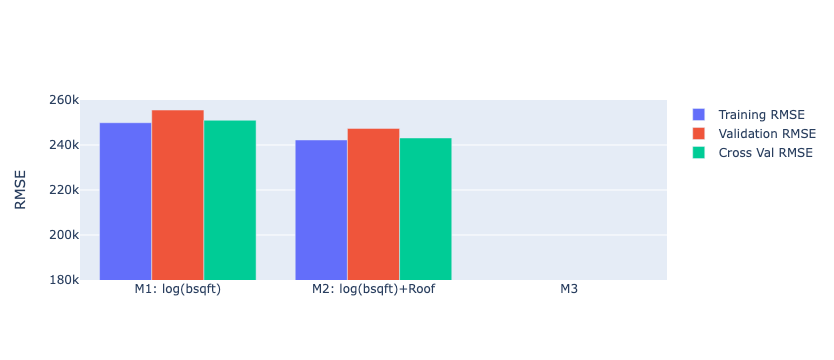

In [139]:
# MODELING STEP 5:  Just run this cell to Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals

model_names[1] = "M2: log(bsqft)+Roof"

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 2 Val Data: Residuals vs. Log(Sale Price)')

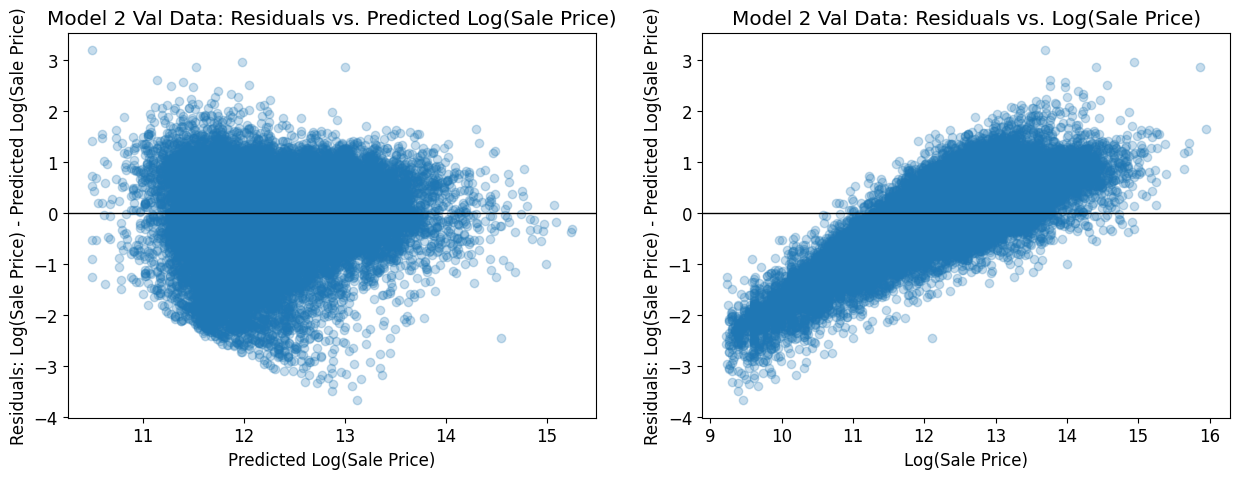

In [140]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots (similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

# x_plt1: predicted log(Sale Price), y_plt1: residuals
x_plt1 = Y_predict_valid_m2  # predicted values for validation data (model 2)
y_plt1 = Y_valid_m2 - Y_predict_valid_m2  # residuals

# x_plt2: actual log(Sale Price), y_plt2: residuals
x_plt2 = Y_valid_m2  # actual values for validation data
y_plt2 = Y_valid_m2 - Y_predict_valid_m2  # residuals


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 2 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 2 Val Data: Residuals vs. Log(Sale Price)")


In [141]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b


We only see a slight decrease in the RMSE with this 2nd model, and our residuals look nearly the same as Model 1, even though the boxplots of Roof Material vs the residuals of Model 1 had indicated it might be a useful feature to add to the model.  

What went wrong?
  
Although there was variation in the boxplots we didn't check the number of data points actually in each different Roof Material Category, which will affect how useful the feature will be in reducing the RMSE.  

To see this, group the `valid_comp` data by Roof Material Type and calculate the proportion of data in each category.  

Set the variable `val_data_prop_roof_type` equal to a `series` with indices given by Roof Material Name and values that are the proportion of validation data of that roof type.

(for example `val_data_prop_roof_type["Shingle/Asphalt"]` should return a float that is the proportion of data points with that type of roof)

In [142]:
val_data_prop_roof_type = valid_comp['Roof Material'].value_counts(normalize=True)

val_data_prop_roof_type

Roof Material
Shingle/Asphalt    0.951513
Tar&Gravel         0.022723
Shake              0.009751
Tile               0.007067
Other              0.004711
Slate              0.004234
Name: proportion, dtype: float64

In [143]:
grader.check("q4b")

q4b results: All test cases passed!

<!-- BEGIN QUESTION -->


<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 5:  Improving the Model



### Question 5a:  Choose an additional feature

It's your turn to choose another feature to add to the model.  Choose one new **quantitative** (not qualitative) feature and create Model 3 incorporating this feature (along with the features we've already chosen in Model 2).    Try to choose a feature that will have a large impact on reducing the RMSE and/or will improve your residual plots.  This can be a raw feature available in the dataset, or a transformation of one of the features in the dataset, or a new feature that you create from the dataset (see Project 1 for ideas).    In the cell below, explain what additional feature you have chosen and why.  Justify your reasoning.  There are optional code cells provided below for you to use when exploring the dataset to determine which feature to add. 

Note:  There is not one single right answer as to which feature to add, however you should make sure the feature decreases the Cross Validation RMSE compared to Model 2 (i.e. we want to improve the model, not make it worse!)  
This problem will be graded based on your reasoning and explanation of the feature you choose, and then on your implementation of incorporating the feature.   

**NOTE** Please don't add additional coding cells below or the Autograder will have issues.  You do not need to use all the coding cells provided. 

### Question 5a Answer Cell:   
In this cell, explain what feature you chose to add and why. Then give the equation for your new model (use Model 2 from above and then add an additional term).   


I am choosing to add Land Square feet to the model. I started my search by looking through other available quantitative features, but Land Square Feet and Age stood out as potentially logical choices. For Land Square Feet, it directly relates to property size, which is intuitively associated with Sale Price. I felt Age had a similar logical or intuitive appeal. I also did a series of analyses, including examining the features distribution, correlations, and residuals pattern, to further investigate if the feature would be a good addition to the model. 

The histogram below of Land Square Feet shows that the distribution is highly skewed, with most values concentrated near zero but with some significantly larger outliers. I was initially concerned with this skewness, but it could also suggest variability, particularly for larger properties, which the model could potentially capture to explain Sale Price better. 

Then I looked at the correlations. The correlation between Land Square Feet and Log Sale Price is 0.176, indicating a weak positive relationship. This relationship suggests that as Land Square Feet increases, the Sale price tends to increase slightly. While this was not strong by any means, the correlation still shows that this feature could have some predictive information. The correlation between Land Square Feet and Residuals from model 2 is approximately -0.016, which is very close to zero. This weak correlation indicates that Land Square Feet is not strongly related to the existing residuals, meaning its predictive information is not already captured by the current model.

Finally, the residuals analysis shows that while there is still some scatter, particularly among smaller land sizes, there appears to be potential for improvement at the higher end of the scale where residuals are more variable. Including Land Square Feet may help capture this relationship and reduce residual errors. 

So I am adding Land Square Feet to the model because it offers some predictive power for explaining Sale Price, does not appear to be redundant with the features already included, and could contribute to improving the model’s performance because of this. In all honesty though, I first added Age to the model as it showed a much higher correlation with log(Sale Price). Surprisingly, when I calculated the cross validation RMSE after adding Age, it was actually slightly higher than the cross validation RMSE in model 2. This caused me to reconsider Land Square Feet, which ended up providing a lower cross validation RMSE than Age and model 2. 


Model 3 Equation: 

\begin{align}
\text{Log Sale Price} &= \theta_1 (\text{Log Building Square Feet}) + \theta_2 (\text{Shingle/Asphalt}) + \theta_3 (\text{Tar\&Gravel}) \\
&+ \theta_4 (\text{Tile}) + \theta_5 (\text{Shake}) + \theta_6 (\text{Other}) \\
&+ \theta_7 (\text{Slate}) + \theta_8 (\text{Land Square Feet})
\end{align}




Index(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material', 'Basement',
       'Basement Finish', 'Central Heating', 'Other Heating', 'Central Air',
       'Fireplaces', 'Attic Type', 'Attic Finish', 'Design Plan',
       'Cathedral Ceiling', 'Construction Quality', 'Site Desirability',
       'Garage 1 Size', 'Garage 1 Material', 'Garage 1 Attachment',
       'Garage 1 Area', 'Garage 2 Size', 'Garage 2 Material',
       'Garage 2 Attachment', 'Garage 2 Area', 'Porch', 'Other Improvements',
       'Building Square Feet', 'Repair Condition', 'Multi Code',
       'Number of Commercial Units', 'Estimate (Land)', 'Estimate (Building)',
       'Deed No.', 'Sale Price', 'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       'O'Hare Noise', 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year',
     

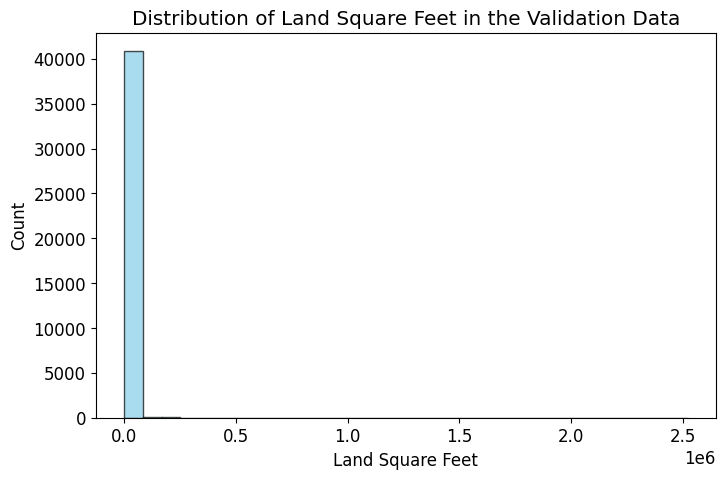

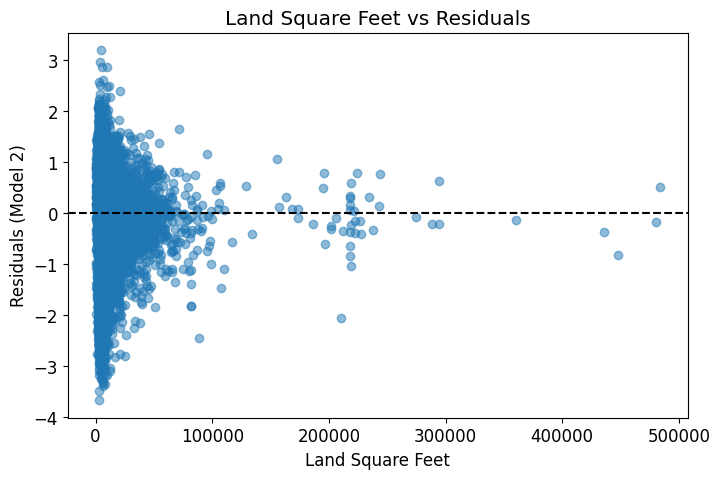

Correlation between Land Square Feet and Log Sale Price: 0.1760909955365289
Correlation between Land Square Feet and Residuals: -0.015880769688252517


In [144]:
# Step 1: Define the feature to analyze
feature_name = "Land Square Feet"  # Change this to explore other features

print(valid.columns)
print(valid_comp.columns)

# Step 2: Visualize the distribution of the chosen feature in the dataset
plt.figure(figsize=(8, 5))
plt.hist(valid[feature_name].dropna(), bins=30, alpha=0.7, color='skyblue', 
         edgecolor='black')
plt.xlabel(feature_name)
plt.ylabel("Count")
plt.title(f"Distribution of {feature_name} in the Validation Data")
plt.show()

# Step 3: Analyze the feature vs Residuals (using valid residuals from Model 2)
valid_with_feature = valid.copy()
valid_with_feature['Residuals'] = Y_valid_m2 - Y_predict_valid_m2  # Add Model 2 residuals

plt.figure(figsize=(8, 5))
plt.scatter(valid_with_feature[feature_name], valid_with_feature['Residuals'], alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel(feature_name)
plt.ylabel("Residuals (Model 2)")
plt.title(f"{feature_name} vs Residuals")
plt.show()

# Step 4: Correlation analysis
feature_correlation_log_price = valid[feature_name].corr(valid_comp['Log Sale Price'])
feature_correlation_residuals = valid_with_feature[feature_name].corr(
    valid_with_feature['Residuals'])

print(f"Correlation between {feature_name} and Log Sale Price:", 
      feature_correlation_log_price)
print(f"Correlation between {feature_name} and Residuals:", feature_correlation_residuals)


# Show work in this cell exploring data to determine which feature to add

In [145]:
...

# Optional code cell for additional work exploring data/ explaining which feature you chose.

Ellipsis

In [146]:
...

# Optional code cell for additional work exploring data/ explaining which feature you chose.

Ellipsis

In [147]:
...

# Optional code cell for additional work exploring data/ explaining which feature you chose.

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 5b:  Create Model 3

In the cells below fill in the code to create and analyze Model 3 (follow the Modeling steps outlined in Questions 3 and 4).

PLEASE DO NOT ADD ANY ADDITIONAL CELLS IN THIS PROBLEM OR IT MIGHT MAKE THE AUTOGRADER FAIL

In [148]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function 
# from Project Part 1, or use the staff's implementation

from feature_func import *

...
# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m3(data):
    
    # You should start by only keeping values with Pure Market Filter = 1
    
    data = data[data["Pure Market Filter"] == 1]
    
    # add log transformed columns
    data = data.copy()
    data["Log Sale Price"] = np.log(data["Sale Price"])
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    # add the land square feet feature 
    data["Land Square Feet"] = data["Land Square Feet"]
    
    # one hot encode roof material
    data = ohe_roof_material(data)
    
    # Select columns for model 3 while ensuring order
    columns_for_model = ["Log Building Square Feet", "Land Square Feet", 
                         "Log Sale Price"] + \
                        [col for col in data.columns if "Roof Material_" in col]
    
    data = data[columns_for_model]
    
    return data


# Process the data for Model 3
processed_train_m3 = process_data_m3(train)

processed_val_m3 = process_data_m3(valid)

# Create X (Dataframe) and Y (series) to use to train the model
X_train_m3 = processed_train_m3.drop(columns="Log Sale Price")
Y_train_m3 = processed_train_m3["Log Sale Price"]

X_valid_m3 = processed_val_m3.drop(columns="Log Sale Price")
Y_valid_m3 = processed_val_m3["Log Sale Price"]


# Take a look at the result
display(X_train_m3.head())
display(Y_train_m3.head())

display(X_valid_m3.head())
display(Y_valid_m3.head())


Log Building Square Feet  Land Square Feet  Roof Material_1.0  \
130829                  7.870166            9632.0                1.0   
193890                  7.002156            4183.0                1.0   
30507                   6.851185            6632.0                1.0   
91308                   7.228388            2256.0                1.0   
131132                  7.990915           10480.0                1.0   

        Roof Material_2.0  Roof Material_3.0  Roof Material_4.0  \
130829                0.0                0.0                0.0   
193890                0.0                0.0                0.0   
30507                 0.0                0.0                0.0   
91308                 0.0                0.0                0.0   
131132                0.0                0.0                0.0   

        Roof Material_5.0  Roof Material_6.0  
130829                0.0                0.0  
193890                0.0                0.0  
30507                 0.0                0.0  
91308                 0.0                0.0  
131132                0.0                0.0

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet  Land Square Feet  Roof Material_1.0  \
50636                   7.310550            3125.0                1.0   
82485                   7.325808            4960.0                1.0   
193966                  7.090077            7488.0                1.0   
160612                  7.281386           12864.0                1.0   
7028                    7.118016            4158.0                1.0   

        Roof Material_2.0  Roof Material_3.0  Roof Material_4.0  \
50636                 0.0                0.0                0.0   
82485                 0.0                0.0                0.0   
193966                0.0                0.0                0.0   
160612                0.0                0.0                0.0   
7028                  0.0                0.0                0.0   

        Roof Material_5.0  Roof Material_6.0  
50636                 0.0                0.0  
82485                 0.0                0.0  
193966                0.0                0.0  
160612                0.0                0.0  
7028                  0.0                0.0

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [149]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# Be sure to set fit_intercept to False, since we are incorporating one-hot-encoded data
linear_model_m3 = lm.LinearRegression(fit_intercept=False)

linear_model_m3.fit(X_train_m3, Y_train_m3)

# your code above this line to create regression model for Model 3

Y_predict_train_m3 = linear_model_m3.predict(X_train_m3)

Y_predict_valid_m3 = linear_model_m3.predict(X_valid_m3)




In [150]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and test errors for the model (in its units of Log Sale Price)

training_error_log[2] = rmse(Y_predict_train_m3, Y_train_m3)
validation_error_log[2]= rmse(Y_predict_valid_m3, Y_valid_m3)

# Convert predictions and actuals back to original scale - undo log transformation
Y_train_m3_exp = np.exp(Y_train_m3)  # actual sale price for training data
Y_predict_train_m3_exp = np.exp(Y_predict_train_m3)  # predicted sale price for training data

Y_valid_m3_exp = np.exp(Y_valid_m3)  # actual sale price for validation data
Y_predict_valid_m3_exp = np.exp(Y_predict_valid_m3)  # predicted sale price for val data

# Training and test errors for the model (in its original values before the log transform)
training_error[2] = rmse(Y_predict_train_m3_exp, Y_train_m3_exp)
validation_error[2] = rmse(Y_predict_valid_m3_exp, Y_valid_m3_exp)


print("3rd Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(
    training_error_log[2], validation_error_log[2]))
print("3rd Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(
    training_error[2], validation_error[2]))


3rd Model
Training RMSE (log): 0.7483738042823385
Validation RMSE (log): 0.7479894313110084

3rd Model 
Training RMSE: 242115.98698909127
Validation RMSE: 247142.56572707082



In [151]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

# create new model instance with fit_intercept=False
linear_model_m3_cv = lm.LinearRegression(fit_intercept=False)

# process entire training and validation data (train and val combined)
processed_full_m3 = process_data_m3(training_val_data)

# split into x and y for combined dataset
X_full_m3 = processed_full_m3.drop(columns="Log Sale Price")
Y_full_m3 = processed_full_m3["Log Sale Price"]

# your code above this line to use 5-fold cross-validation and 
# output RMSE (in units of dollars)

cv_error[2] = cross_validate_rmse(linear_model_m3_cv, X_full_m3, Y_full_m3)

print("3rd Model Cross Validation RMSE: {}".format(cv_error[2]))



3rd Model Cross Validation RMSE: 242906.0742422669


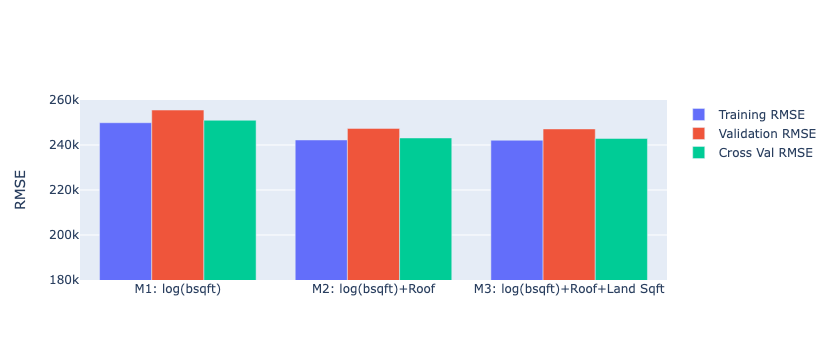

In [152]:
# MODELING STEP 5:  Add a name for your 3rd model describing 
# the features and run this cell to Plot bar graph all 3 models

model_names[2] = "M3: log(bsqft)+Roof+Land Sqft"


fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 3 Val Data: Residuals vs. Log(Sale Price)')

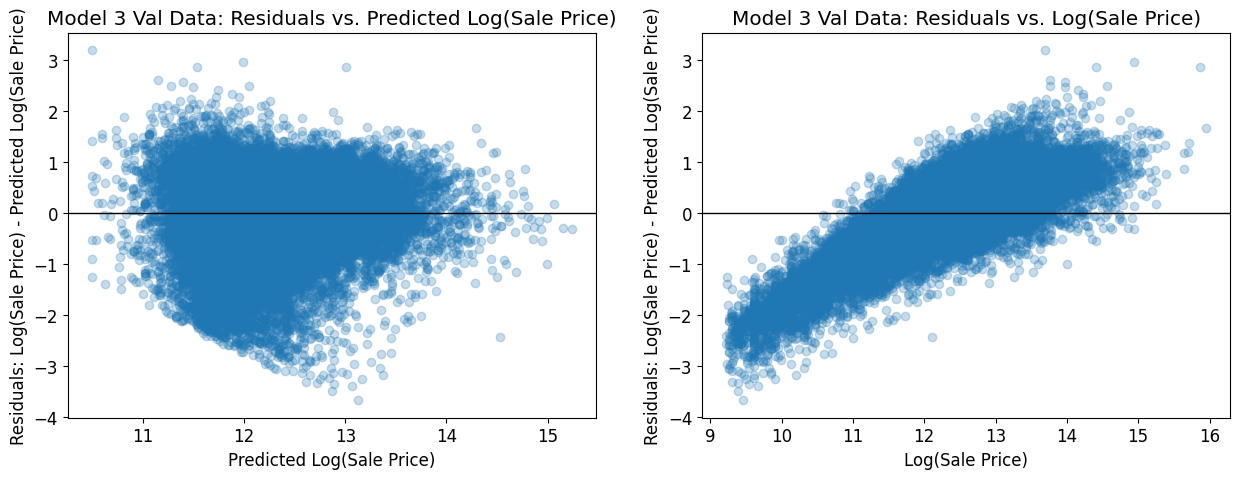

In [153]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots 
#(similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

# x_plt1: predicted log(Sale Price), y_plt1: residuals
x_plt1 = Y_predict_valid_m3  # predicted values for validation data (model 3)
y_plt1 = Y_valid_m3 - Y_predict_valid_m3  # residuals

# x_plt2: actual log(Sale Price), y_plt2: residuals
x_plt2 = Y_valid_m3  # actual values for validation data
y_plt2 = Y_valid_m3 - Y_predict_valid_m3  # residuals


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 3 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 3 Val Data: Residuals vs. Log(Sale Price)")


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 5c

i).  Comment on your RMSE and residual plots from Model 3 compared to the first 2 models.  

ii).  Are the residuals of your model still showing a trend that overestimates lower priced houses and underestimates higher priced houses?   If so, how could you try to address this in the next round of modeling?

iii).  If you had more time to improve your model, what would your next steps be?


**i)** 
Model 1 had the highest Validation RMSE (255,534) and Cross Validation RMSE (250,986). Model 2 improved over Model 1, reducing the Validation RMSE to 247,382 and the Cross Validation RMSE to 243,125. Model 3 achieved the best results, with a Validation RMSE of 247,143 and a slightly lower Cross Validation RMSE of 242,906 compared to Model 2.
The RMSE values indicate that Model 3 has marginally improved over Model 2, demonstrating the benefit of including Land Square Feet as an additional predictor. While I am happy with the improvement and it was hard earned, I am slightly disappointed to see that Model 3 only reduced Model 1’s Cross Validation RMSE by about 8,080. As we talked about earlier in the project, this is not a fair process for a number of reasons, but I expected more of a change with what we added to the models. 

Similarly, the differences in the residual plots across the three models are quite subtle. The RMSE did improve between models, but not significantly, and this is reflected in the residual plots. That said, I do think that the plots from Model 1 are noticeably more spread out than the plots from Model 3, but just barely. 

**ii)** 
Yes, the residuals are still showing a trend that overestimates lower priced houses and underestimates higher priced houses. This can most noticeably be seen in the Model 3 plot on the right. Here, residuals are systematically below zero at the low end of log(Sale Price) and above zero at the high end, indicating that lower value homes are being predicted to be higher value than they are. This can also be seen in the left side plot, where there is a clustering of homes with negative residuals on the lower value end of the plot that is not reflected in the higher value end, though I feel this is less visually apparent. 

To address this issue in future rounds of modeling, we could try log transforming additional features. Log Sale Price is already log transformed, but other features, like Land Square Feet, could benefit from a log transformation as well. We could also try incorporating nonlinear features. A polynomial term, like a square or cubic term, would be interesting to experiment with and could allow the model to better capture curvature in the relationship between features and the target variable. Separate from changing how we use the data we have, we could also potentially add additional data, like racial or socioeconomic data, that could benefit the model. 

**iii)** 
If I had unlimited time, I would start by exploring log transformations on more features, notably Land Square Feet. This could help improve linearity and reduce the impact of outliers. Then, I’d circle back on adding Age to model 3, I was surprised that it actually increased the RMSE and am curious about why. After that, I would experiment with polynomial or nonlinear features by squaring or cubing key predictors like Log Building Square Feet or Land Square Feet to try to capture curvature in the relationships. These nonlinear terms could help address the systematic over or underestimation seen in the residuals. I would also try to source additional data, the data available does not include any racial or socioeconomic data, which might be helpful. 




<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Question 6: Evaluating the Model in Context

<br>

---
## Question 6a

When evaluating your model, we used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

Generally speaking, a residual is the difference between the actual value and the predicted value from the model. In the context of this question, a residual is the difference between the actual sale price or value and the predicted sale price or value of a home:

$$
Residual = Actual Sale Price - Predicted Sale Price
$$

When the residual is positive (actual value > predicted value), then the property was undervalued by the model. For the homeowner, this can affect the amount they pay in property taxes if the predicted value is used in the assessment process. This undervaluation would cause the homeowner to pay less in property taxes than they should. While this could benefit individual homeowners in the short term, it is an inaccuracy that undermines fairness and could ultimately be detrimental to homeowners if undervaluations are concentrated in certain areas, leading to lack of funding for public services in those areas. Even if the undervaluations don’t lead to a lack of funding, this is an inequitable distribution of the tax burden. 

When the residual is negative (actual value < predicted value), the property was overvalued by the model. This has the opposite impact on the homeowner, they may pay higher property taxes than they should. This creates an undue financial burden for the homeowner, regardless of their socioeconomic status, but will be particularly harmful for marginalized or low income homeowners. As with a positive residual, this is still an inequitable distribution of the tax burden. 



<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

<!-- BEGIN QUESTION -->

<br>

---

## Question 6b

Reflecting back on your exploration in Questions 5 and 6a, in your own words, what makes a model's predictions of property values for tax assessment purposes "fair"? 

This question is open-ended and part of your answer may depend upon your specific model; we are looking for thoughtfulness and engagement with the material, not correctness. 

**Hint:** Some guiding questions to reflect on as you answer the question above: What is the relationship between RMSE, accuracy, and fairness as you have defined it? Is a model with a low RMSE necessarily accurate? Is a model with a low RMSE necessarily "fair"? Is there any difference between your answers to the previous two questions? And if so, why?

This is a great question about the pragmatics and/or semantics of the word “fair.” In my opinion, there are multiple meanings of “fair” and some of them do mean “accurate,” but not necessarily all of them. In the relationship between RMSE, accuracy, and fairness, RMSE measures the average difference between the predicted and actual values. A lower RMSE indicates that the model’s predictions are closer to the actual values, so it improves accuracy, but that doesn’t necessarily equate fairness in my eyes. For example, a model could have a low RMSE overall, but systematically overvalue or undervalue certain properties based on hidden biases in the data, like properties in marginalized communities. To me, fairness requires that errors be evenly distributed across different subsets of the population or property types, not disproportionately affecting any group. So RMSE is an indicator or measure of accuracy, but not inherently a measure of fairness, fairness depends on how errors are distributed across the population. 

So is a model with a low RMSE necessarily accurate and/or fair? I believe it is at least more accurate, a low RMSE suggests that the model is accurate **on average** because it reduces the error between predicted and actual values. This does not mean that a low RMSE model is accurate for everyone or every group, though. If the model systematically underestimates higher value homes and overestimates lower value homes, the overall RMSE could still appear low, but the model would not be accurate for every individual group. RMSE does not differentiate between systematic biases and random errors, it only measures overall error magnitude. Due to this, a low RMSE does not ensure that all groups or individuals are treated equitably or with fairness. For me, fairness is more about how evenly the residuals are distributed, not about the more global RMSE. 

So in my opinion, there is a key difference in my answers. RMSE primarily measures accuracy, which is an aggregate error metric. Fairness considers the distribution of errors, and in this context, addresses whether specific groups are consistently over or under predicted. A model can minimize RMSE while still producing unfair predictions because RMSE alone isn’t well suited for identifying systemic inequity. 


<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Extra Credit:  How Low Can You Go?   Create Your Own Model and Check RMSE on the Test Data

<br>

---



For **extra credit**, you can create your own model to try to improve the RMSE and residual plots even further.    

The tables below provide scoring guidelines for the extra credit opportunity in this problem. 
If your RMSE lies in a particular range, you will receive the number of points associated with that range.



### Extra Credit Grading Scheme

**Important**: while your Validation RMSE can be checked at any time in this notebook, your Test RMSE can only be checked once by submitting your model’s predictions to Gradescope. The thresholds are as follows:

Extra Credit Points | +5 | +4 | +3  | +2 | + 1
--- | --- | --- | --- | --- | ---
Validation RMSE | Less than 200k | [200k, 210k) | [210k, 220k) | [220k, 230k)  | [230k, 235k)

Extra Credit Points | +5 | +4 | +3  | +2 | + 1
--- | --- | --- | --- | --- | ---
Test RMSE | Less than 200k | [200k, 210k) | [210k, 220k) | [220k, 230k)| [230k, 235k)

<br><br>

To receive these points, you need to show your work in the cells below AND complete the EXPLANATION STEP at the end (explaining what you did to create your model).  

You ALSO MUST UPLOAD your test prediction .csv to the **"Project 2 Extra Credit Test Predictions"** assignment in Gradescope to receive extra credit for your test predictions.

---



## Some notes before you start

- **If you are running into memory issues, restart the kernel and only run the cells you need to.**   If needed you can use the commented cell below (question cell) that contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed independently code-wise from the remainder of the project, and you do not need to rerun the cell at the top of this notebook. The autograder will have more than 4GB of memory, so you will not lose credit as long as your solution to this question is within the total memory (4GB) limits of DataHub. By default, we reset the memory and clear all variables using `%reset -f`. If you want to delete specific variables, you may also use `del` in place of `%reset -f%`. For example, the following code will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier.
- To avoid memory issues, you do not need to include cross validation for this step.  Your score will be based on the Validation Data set RMSE and the Test dataset RMSE.
- **Note: If you need the data again after deleting the variables or resetting, you must reload them again.**
- You will be predicting `Log Sale Price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e., if one of your `Log Sale Price` predictions is 60, it is too large; $e^{60}$ is too big!)
- You MUST remove any additional new cells you add before submitting to Gradescope to avoid any autograder errors. 


**PLEASE READ THE ABOVE MESSAGE CAREFULLY!**

**Hints:** 
- Some features may have missing values in the test set but not in the training set (especially if you're one-hot-encoding). Make sure `process_data_ec` handles missing values appropriately for each feature!



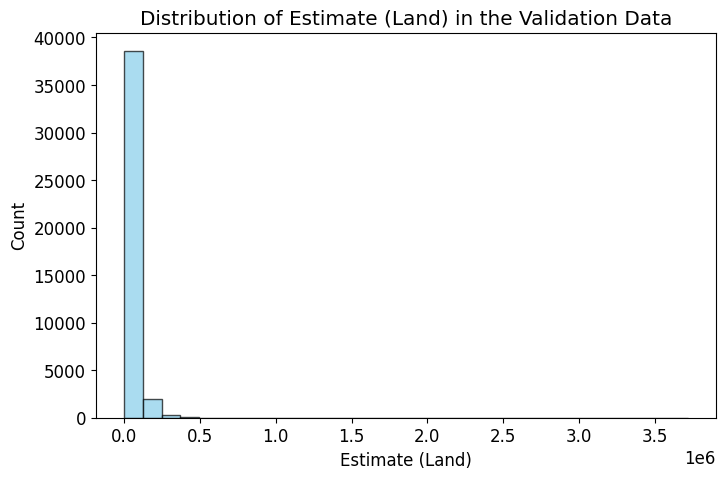

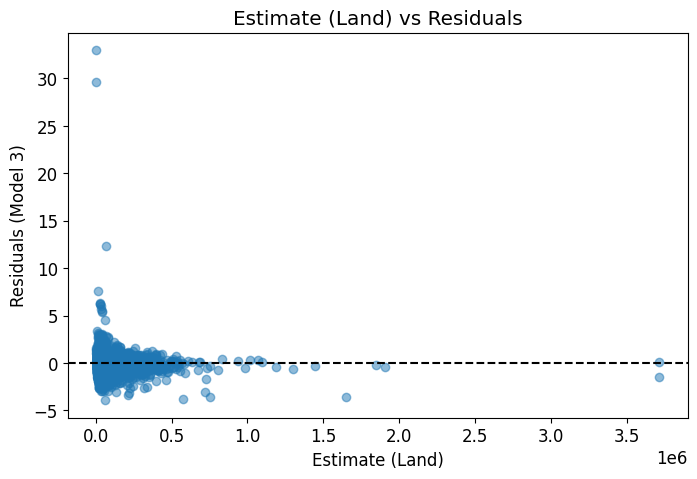

Correlation between Estimate (Land) and Log Sale Price: 0.47784983103177936
Correlation between Estimate (Land) and Residuals: -0.036803871974194165


In [163]:
# define the feature to analyze
feature_name = "Estimate (Land)"  # change as needed for exploration

# ensure the feature exists and has no missing values
#print("Available Columns in 'valid':", valid.columns)
#print("Available Columns in 'valid_comp':", valid_comp.columns)

# visualize the distribution of the chosen feature in the dataset
plt.figure(figsize=(8, 5))
plt.hist(valid[feature_name].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel(feature_name)
plt.ylabel("Count")
plt.title(f"Distribution of {feature_name} in the Validation Data")
plt.show()


# analyze the feature vs residuals using residuals from EC model
valid_with_feature = valid.copy()
valid_with_feature['Residuals'] = Y_valid_ec - Y_predict_valid_ec  # update to EC model residuals

# plot the feature vs residuals
plt.figure(figsize=(8, 5))
plt.scatter(valid_with_feature[feature_name].dropna(), 
            valid_with_feature['Residuals'], alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel(feature_name)
plt.ylabel("Residuals (Model 3)")
plt.title(f"{feature_name} vs Residuals")
plt.show()

# correlation analysis
feature_correlation_log_price = valid[feature_name].corr(valid_comp['Log Sale Price'])
feature_correlation_residuals = valid_with_feature[feature_name].corr(valid_with_feature['Residuals'])

print(f"Correlation between {feature_name} and Log Sale Price:", 
      feature_correlation_log_price)
print(f"Correlation between {feature_name} and Residuals:", feature_correlation_residuals)

# handle missing values if any
if valid[feature_name].isnull().sum() > 0:
    print(f"Missing values detected in {feature_name}: {valid[feature_name].isnull().sum()}")
    print("Consider filling missing values for test set predictions.")

# Optional code cell for additional work exploring data/ explaining which feature you chose.
# You can add additional code cells directly below this if needed.

In [157]:

# Optional code cell for additional work exploring data/ explaining which feature you chose.

In [ ]:
#Optional cell to try if you're having memory issues (i.e. if kernel keeps dying)


# If you're having memory issues, uncomment the lines below to clean up memory from previous questions and reinitialize Otter!



# MAKE SURE TO RECOMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!

#%reset -f
#import otter
#grader = otter.Notebook("ProjPart2.ipynb")


import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

import plotly.graph_objects as go

from ds100_utils import *
from feature_func import *




training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

# COPY THESE FUNCTIONS FROM ABOVE

#def rmse(predicted, actual):
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    
    # find the squared differences
    squared_diff = (predicted - actual) ** 2
    
    # calc the mean of squared differences
    mean_squared_error = squared_diff.mean()
    
    # return square root of mean squared error
    return np.sqrt(mean_squared_error) 

    


#def train_val_split(data):
def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    # calc the split index for 80%
    split_index = int(data_len * 0.8)
    
    #use shuffled indices to split data
    train_indices = shuffled_indices[:split_index]
    validation_indices = shuffled_indices[split_index:]
    
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    
    return train, validation

    
    

## This makes the train-test split in this section reproducible across different runs of the notebook. DO NOT CHANGE THIS RANDOM SEED.
np.random.seed(1337)

train, valid = train_val_split(training_val_data)


<!-- BEGIN QUESTION -->

## Extra Credit Step 1: Creating Your Model
Complete the modeling steps (you can skip the cross validation step to save memory) in the cells below.

DO NOT ADD ANY EXTRA CELLS BELOW (for this part of the problem)

In [167]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function from Project Part 1
# or use the staff's implementation

from feature_func import *


def ohe_property_class(data):
    """
    One-hot encodes 'Property Class.' New column form is 'Property Class_CLASS'.
    """
    # init OneHotEncoder
    oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # fit and transform the property class column
    property_class_ohe = oh_enc.fit_transform(data[['Property Class']])
    
    # get the encoded column names
    ohe_columns = oh_enc.get_feature_names_out(['Property Class'])
    ohe_df = pd.DataFrame(property_class_ohe, columns=ohe_columns, index=data.index)
    
    # combine encoded columns w/ original data and drop property class
    new_data = pd.concat([data, ohe_df], axis=1)
    new_data = new_data.drop(columns=['Property Class'])
    
    return new_data


def ohe_central_air(data):
    """
    One-hot encodes the Central Air feature. 
    New columns are "Central Air_YES" and "Central Air_NO".
    """
    oh_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    central_air_ohe = oh_enc.fit_transform(data[['Central Air']])
    ohe_columns = oh_enc.get_feature_names_out(['Central Air'])
    ohe_df = pd.DataFrame(central_air_ohe, columns=ohe_columns, index=data.index)
    new_data = pd.concat([data, ohe_df], axis=1)
    return new_data



# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_ec(data, is_test_set=False):
    
    #copy to avoid overwriting 
    data = data.copy()
    
    # protect against missing values
    data['Property Class'] = data['Property Class'].fillna('Unknown')
    data['Central Air'] = data['Central Air'].fillna('N')

    # handle missing/zero values in numerical columns
    data['Building Square Feet'] = data['Building Square Feet'].replace(
        0, np.nan).fillna(data['Building Square Feet'].median())
    
    # add estimate building log transformed feature 
    if "Estimate (Building)" in data.columns:
        data['Log Estimate_Building'] = np.log(
            data['Estimate (Building)'] + 1) #avoids log(0)
        
    # add estimate land log transformed feature
    if "Estimate (Land)" in data.columns:
        data['Log Estimate_Land'] = np.log(data['Estimate (Land)'] + 1) #avoids log(0)
    
    # processing specific to the training/validation set from piazza
    if not is_test_set:
        # filter rows 
        data = data[data["Pure Market Filter"] == 1]
        
        data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # log transform building sqft
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    # one hot encode property class, roof material, central air, for both train and test
    data = ohe_property_class(data) 
    data = ohe_roof_material(data)
    data = ohe_central_air(data)
    
  
    # central air x roof material interaction
    for col in data.columns:
        if "Roof Material_" in col:
            data[f"CentralAir_Roof_{col}"] = data[col] * data["Central Air_1.0"]
    
    # central air x log building sqft interaction 
    data["CentralAir_BuildingSqft"] = data["Central Air_1.0"] * data[
        "Log Building Square Feet"]
    
    # log estimate land x property class interaction
    property_class_cols = [col for col in data.columns if "Property Class_" in col]
    for col in property_class_cols:
        data[f"{col}_LogEstimateLand"] = data[col] * data["Log Estimate_Land"]
    
    
    #identify all ohe property class columns, 
    #then loop through and create interaction term
    # w/ log building sqft
    property_class_cols = [col for col in data.columns if "Property Class_" in col]
    for col in property_class_cols:
        data[f"{col}_BuildingSqft"] = data[col] * data["Log Building Square Feet"]
        
    # add estimate building interactions
    if "Log Estimate_Building" in data.columns:
        for col in property_class_cols:
            data[f"{col}_EstimateBuilding"] = data[col] * data["Log Estimate_Building"]
        
        if "Central Air_1.0" in data.columns:
            data["CentralAir_EstimateBuilding"] = data["Central Air_1.0"] * data[
                "Log Estimate_Building"]


    # drop unnecessary columns keeping selected columns for model
    # w/ the test set, log sale price NOT included
    columns_for_model = ["Log Building Square Feet", "CentralAir_BuildingSqft", 
                         "Log Estimate_Land", "Log Estimate_Building"] + \
                        [col for col in data.columns if "Roof Material_" in col] + \
                        [col for col in data.columns if "Central Air_" in col] + \
                        [col for col in data.columns if "Property Class_" in col and 
                         "_BuildingSqft" not in col] + \
                        [col for col in data.columns if "CentralAir_Roof_" in col] + \
                        [col for col in data.columns if "_EstimateBuilding" in col] + \
                        [col for col in data.columns if "_LogEstimateLand" in col]
                        
    
    if not is_test_set:
        columns_for_model.append("Log Sale Price")
    
    # select relevant columns
    data = data[columns_for_model]
    
    return data

    
# Process the data 
processed_train_ec = process_data_ec(train, is_test_set=False)

processed_val_ec = process_data_ec(valid, is_test_set=False)


X_train_ec = processed_train_ec.drop(columns="Log Sale Price")
Y_train_ec = processed_train_ec["Log Sale Price"]

X_valid_ec = processed_val_ec.drop(columns="Log Sale Price")
Y_valid_ec = processed_val_ec["Log Sale Price"]


# Take a look at the result
#display(X_train_ec.head())
#display(Y_train_ec.head())

#display(X_valid_ec.head())
#display(Y_valid_ec.head())


#display(X_valid_m3.head())
#display(Y_valid_m3.head())




In [168]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# If you are are incorporating one-hot-encoded data, set the fit_intercept to False

linear_model_ec = lm.LinearRegression(fit_intercept=False)

linear_model_ec.fit(X_train_ec, Y_train_ec)

# your code above this line to create regression model for extra credit model  

Y_predict_train_ec = linear_model_ec.predict(X_train_ec)

Y_predict_valid_ec = linear_model_ec.predict(X_valid_ec)


In [169]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and validation errors for the model (in units of Log Sale Price)
training_error_ec_log = rmse(Y_predict_train_ec, Y_train_ec)
validation_error_ec_log = rmse(Y_predict_valid_ec, Y_valid_ec)

# convert predictions and actuals back to the original scale - undo log transformation
Y_train_ec_exp = np.exp(Y_train_ec)  # actual sale price for training data
Y_predict_train_ec_exp = np.exp(Y_predict_train_ec)  # pred sale price for training data

Y_valid_ec_exp = np.exp(Y_valid_ec)  # actual sale price for validation data
Y_predict_valid_ec_exp = np.exp(Y_predict_valid_ec)  # pred sale price for validation data

# Training and test errors for the model (in its original values before the log transform)
training_error_ec = rmse(Y_predict_train_ec_exp, Y_train_ec_exp)
validation_error_ec = rmse(Y_predict_valid_ec_exp, Y_valid_ec_exp)


print("Extra Credit Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(
    training_error_ec_log, validation_error_ec_log))
print("Extra Credit \nTraining RMSE: {}\nValidation RMSE: {}\n".format(
    training_error_ec, validation_error_ec))

# used for feature or linear regression coefficients
feature_coeff = pd.DataFrame({
    "Feature": X_train_ec.columns,
    "Coefficient": linear_model_ec.coef_
}).sort_values(by="Coefficient", ascending=False)

print(feature_coeff)



Extra Credit Model
Training RMSE (log): 0.5323980986655747
Validation RMSE (log): 0.5963795617529222

Extra Credit 
Training RMSE: 186441.73051742604
Validation RMSE: 194739.58099564843

                               Feature  Coefficient
25                  Property Class_209     8.526023
22                  Property Class_206     7.458165
20                  Property Class_204     5.273868
26                  Property Class_278     4.241845
17                     Central Air_1.0     4.059311
..                                 ...          ...
78         CentralAir_EstimateBuilding    -0.352177
30  Property Class_205_LogEstimateLand    -0.398790
82  Property Class_205_LogEstimateLand    -0.398790
18                  Property Class_202    -3.197165
19                  Property Class_203   -25.099698

[106 rows x 2 columns]


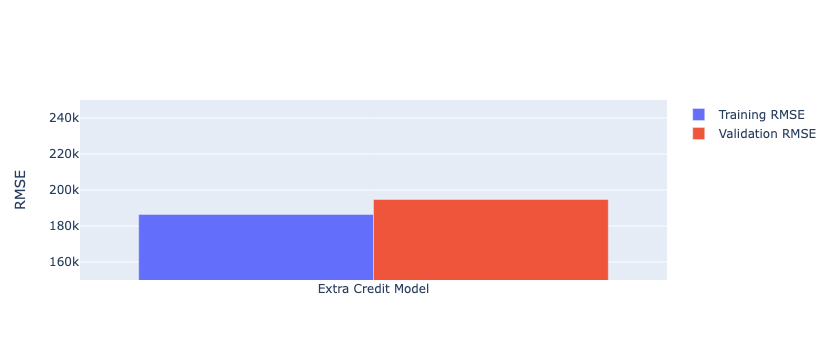

In [170]:
# Optional: Run this cell to visualize

fig = go.Figure([
go.Bar(x = ["Extra Credit Model"], y = [training_error_ec], name="Training RMSE"),
go.Bar(x = ["Extra Credit Model"], y = [validation_error_ec], name="Validation RMSE"),

])


fig
fig.update_yaxes(range=[150000,250000], title="RMSE")


Text(0.5, 1.0, 'EC Val Data: Residuals vs. Log(Sale Price)')

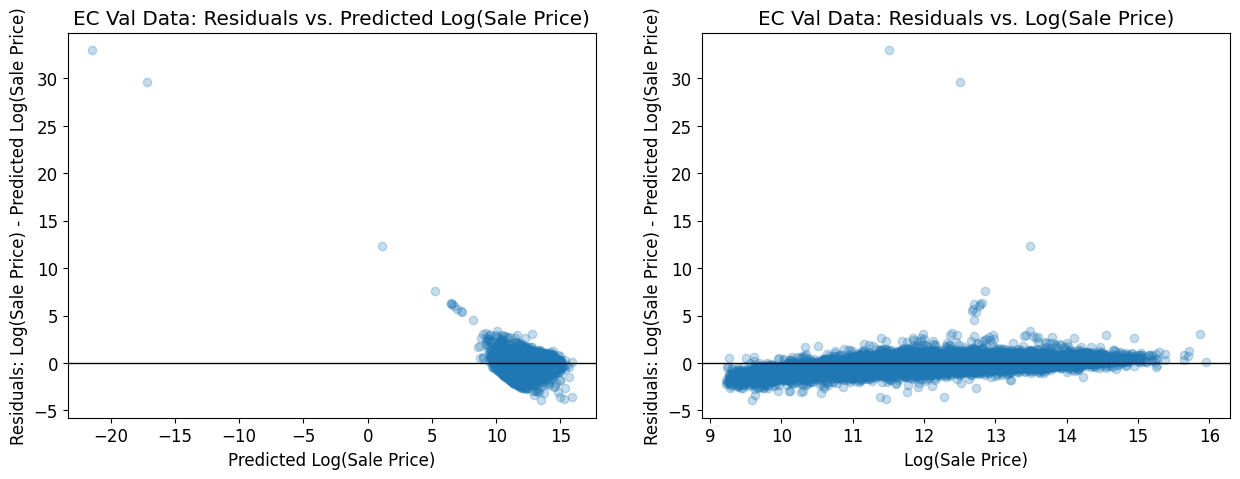

In [171]:
# MODELING STEP 5: Plot 2 side-by-side residual plots for validation data

fig, ax = plt.subplots(1,2, figsize=(15, 5))

residuals_ec = Y_valid_ec - Y_predict_valid_ec  #log(sale price)-predicted log(sale price) 

x_plt1 = Y_predict_valid_ec  # predicted log(sale price)
y_plt1 = residuals_ec

x_plt2 = Y_valid_ec          # actual log(sale price)
y_plt2 = residuals_ec


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("EC Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("EC Val Data: Residuals vs. Log(Sale Price)")


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Extra Credit Step 2:  Explanation (Required for points on model above):

Explain what you did to create your model.  What versions did you try?  What worked and what didn't? 

Comment on the RMSE and residual plots from your model.   Are the residuals of your model still showing a trend that overestimates lower priced houses and underestimates higher priced houses? 


To develop the extra credit model, I first searched for features with strong correlations to Log Sale Price, particularly qualitative features that were excluded from Model 3\. There were dozens of iterations and experiments to identify impactful variables and interactions. Here is a summary of the steps taken:

1. Initial Exploration and Model:   
   1. I started by evaluating correlations between Log Sale Price and various qualitative features, selecting primarily based on how much I expected they would factor into Sale Price. Property Class was my first standout feature, it had a good correlation and the relationship to Sale Price felt intuitive.   
   2. The first model included Log Building Square Feet, Log Sale Price, and Property Class. This initial model resulted in a higher RMSE than Model 3\.   
2. Adding Model 3 Features:   
   1. To try to match or exceed Model 3’s performance, I added Roof Material and Land Square Feet. This did improve the RMSE, but it was only marginally better than Model 3\.   
3. Adding Central Air:   
   1. After recognizing the strong correlation between Central Air and Log Sale Price, I added it to the model as well. This was an improvement as well, but not significantly.  
4. Testing Age and Utilizing Feature Coefficients:  
   1. I briefly included Age due to its moderate correlation, but it resulted in virtually zero improvement.   
   2. At this point I also began checking Feature or Linear Regression Coefficients to factor in the strength and direction of the relationship between each feature and Log Sale Price. With this data, I saw how little Age and Land Square Feet were contributing, so these were removed.   
5. Experimenting with Feature Interactions:   
   1. So far, I had not improved on Model 3’s RMSE in any significant way, so I tested some interaction terms:   
      1. Central Air x Roof Material and Central Air x Log Building Square Feet showed meaningful improvement, so I kept these terms.   
      2. I also tested Property Class x Log Building Square Feet, but it had little effect on RMSE, so I removed it.   
6. Standardization of Features:   
   1. I briefly standardized Log Building Square Feet, but this failed to improve RMSE, so I reverted back to the original scale.   
7. Breakthrough with Price per Square Foot:   
   1. Introducing Price per Square Foot and its log transformation caused a significant drop in RMSE. However, the training RMSE value was effectively 0, which seemed too good to be true and indicative of a problematic model.   
   2. After a closer look, I realized that Log Price per Sqft was highly collinear with Log Building Square Feet and other variables, causing the model to overfit.   
8. Refining Log Price per Sqft:   
   1. To address the collinearity issue without losing the benefits of Log Price per Sqft, I tried using Log Price per Sqft in interactions instead of on its own. I created:   
      1. Log Price per Sqft x Property Class  
      2. Log Price per Sqft x Central Air  
      3. (Log Price per Sqft)^2  
   2. These versions produced more realistic RMSE values, all under the goal of 200k. Log Price per Sqft x Property Class was the best iteration with the lowest RMSE:   
      1. Training RMSE: 75,368  
      2. Validation RMSE: 95,407  
9. Downfall of Log Price per Sqft:   
   1. Regrettably, in my excitement about the low RMSE values, I overlooked the guidelines, my own code comments, and consequently forgot that Sale Price was not included in the test data. So my beloved Log Price per Sqft feature was doomed to shine only in my heart and the training data. With quiet resignation, I pressed onward.  
10. Adding Estimate Features:   
    1. After the painful realization that Log Price per Sqft was unusable for the test set, I pivoted to features that would be available in both the training and test data. Estimate (Land) and Estimate (Building) both had strong correlations with Log Sale Price, and were similar enough in nature to the Sale Price based features that I thought they might have a similar effect on RMSE. Both were log transformed to align with the model’s existing features. Interactions include:   
       1. Log Estimate (Land) x Property Class  
       2. Log Estimate (Building) x Central Air  
    2. The result of these additions was a significant reduction in RMSE, bringing the model from roughly 230k to below 200k.   
11. Challenges with Incorporating Town and Neighborhood:   
    1. I attempted to include Town and Neighborhood, which had promising correlations with Log Sale Price. Unfortunately, one-hot encoding errors prevented this. I tried multiple fixes, including a global encoder at one point, but I wasn’t able to solve the issues. I intended on coming back to this problem after exploring alternative features, but the alternatives ended up being successful. 

The final model uses a combination of Log Building Sqft, Central Air, Roof Material, Property Class, Log Estimate (Land), and Log Estimate (Building) features to achieve a Training RMSE of about 186,441 and Validation RMSE of about 194,739. While this is substantially higher than the RMSE from the model including Log Price per Sqft, these results better adhere to the logic and guidelines of the assignment, and they are still a marked improvement over Model 3\. 

The residual plots show a notable improvement compared to earlier versions as well. Residuals are now more tightly clustered around zero, indicating better overall model performance. There is a slight trend where the lower priced houses have positive residuals, suggesting some underestimation, but all patterns are much less pronounced compared to earlier models. While there is room for further refinement, the improvements reflect the effectiveness of the new features.  


<!-- END QUESTION -->

## Extra Credit Step 3: Create and Submit Test Set Predictions to Gradescope

Now it's time to test your model on the actual test set.  You are only allowed to submit to Gradescope once, so wait until you have the best version of your model.    

The test data is in the dataframe `test_data`.  

Process the test data and run it through your model. Store your predictions from the test_data in the variable `Y_test_pred`.  These should be in units Log Sale Price (you do not need to exponentiate them).  

Then run the cell provided below to create a .csv file to store your predictions on the test set and submit this .csv to the Gradescope Assignment: **"Project 2 Extra Credit Test Predictions"**. 
Note that **you will not receive credit for the test set predictions (i.e. up to 10 points) unless you submit your.csv to the Gradescope assignment**!


In [164]:
# Cells to process test_data and run the model on it.  You CAN add any additional cells below
# Note: You can't remove any test_data cells.  
processed_test_data = process_data_ec(test_data, is_test_set=True)


print(processed_test_data.isnull().sum())


Log Building Square Feet                               0
CentralAir_BuildingSqft                                0
Log Estimate_Land                                      0
Log Estimate_Building                                  0
Roof Material_1.0                                      0
                                                      ..
Property Class_206_LogEstimateLand_EstimateBuilding    0
Property Class_207_LogEstimateLand_EstimateBuilding    0
Property Class_208_LogEstimateLand_EstimateBuilding    0
Property Class_209_LogEstimateLand_EstimateBuilding    0
Property Class_278_LogEstimateLand_EstimateBuilding    0
Length: 106, dtype: int64


In [165]:
#processed_test_data = process_data_ec(test_data, is_test_set=True)
#Store your predictions for the test set in Y_test_pred (these should be in units of Log Sale Price)
Y_test_pred = linear_model_ec.predict(processed_test_data)

max_log = Y_test_pred.max()
print(f"Maximum Log Sale Price Prediction: {max_log}")

# test for unreasonably high values
if max_log > 20: 
    print("Warning: Some predictions are massive and may cause headaches.")
else:
    print("All predictions appear reasonable for exponentiation.")

Maximum Log Sale Price Prediction: 16.744802708371942
All predictions appear reasonable for exponentiation.


In [292]:
# Run this file to create the .csv of your predictions for the test set to upload to the assignment 
# in Gradescope labeled Project 2 Extra Credit Test Predictions to have it checked.

from datetime import datetime

#Store your predictions for the test set in Y_test_pred (these should be in units of Log Sale Price)


# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You MUST now upload this CSV file to the Gradescope assignment "Project 2 Extra Credit Test Predictions" for scoring.')

Created a CSV file: submission_2024-12-17T01:32:19.csv.
You MUST now upload this CSV file to the Gradescope assignment "Project 2 Extra Credit Test Predictions" for scoring.


## Congratulations! You have finished the Project - Part 2


If you discussed this assignment with any other students in the class (in a manner that is acceptable as described by the Collaboration policy above) please **include their names** here:

**Collaborators**: *list collaborators here*

### Submission Instructions

Before proceeding any further, **save this notebook.**

After running the `grader.export()` cell provided below, **2 files will be created**: a zip file and pdf file.  You can download them using the links provided below OR by finding them in the same folder where this juptyer notebook resides in your JuptyerHub.

To receive credit on this assignment, **you must submit BOTH of these files
to their respective Gradescope portals:** 

* **Project Part 2 Autograded**: Submit the zip file that is output by the `grader.export()` cell below to the Autograded assignment in Gradescope.

* **Project Part 2 Manually Graded**: Submit your ProjectPart2.PDF to the  Manually Graded assignment in Gradescope.  **YOU MUST SELECT THE PAGES CORRESPONDING TO EACH QUESTION WHEN YOU UPLOAD TO GRADESCOPE.  IF NOT, YOU WILL LOSE POINTS**   Also, **check** that all of your plots **and** all lines of your code are showing up in your PDF before submitting.  If not, you will not receive credit for your plots/code.  

* **Extra Credit Submission**:  If you completed the extra credit, to receive credit for the Test Case prediction you must submit your Test Case prediction.csv (generated in the last cell of the extra credit section) to the Gradescope assignment titled "Project 2 Extra Credit Test Predictions"

**You are responsible for ensuring your submission follows our requirements. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

AFTER running the cell below, click on <a href='ProjPart2.pdf' download>this link to download the PDF </a> to upload to Gradescope.  There will be a separate link that appears after running the cell below with a link to download the zip file to upload to Gradescope.

In [166]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1c results: All test cases passed!

    q2d results: All test cases passed!

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q3c results: All test cases passed!

    q3d results: All test cases passed!

    q3e results: All test cases passed!

    q3f results: All test cases passed!

    q4a results: All test cases passed!

    q4b results: All test cases passed!
